# Sistema de predicción de ventas (ARIMA)

Este notebook resuelve el proyecto de **Series de tiempo** (ventas) siguiendo los pasos del enunciado.

**Dataset (URL):**  
https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv

## Objetivos
1. Cargar el dataset y construir la serie temporal (índice de fechas + variable de ventas).
2. Analizar: **tensor (frecuencia)**, **tendencia**, **estacionariedad** y **ruido/variabilidad**.
3. Entrenar un **ARIMA** (idealmente con `auto_arima`).
4. Predecir en el conjunto de test y medir el rendimiento.
5. Guardar el modelo entrenado.

In [12]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install statsmodels pmdarima
import sys
!{sys.executable} -m pip install -U scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [13]:
# ==============================
# 0) Imports y configuración
# ==============================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tests y utilidades de series temporales
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Intentamos usar auto_arima (recomendado). Si no está disponible, usamos statsmodels ARIMA + mini-grid.
AUTO_ARIMA_AVAILABLE = True
try:
    from pmdarima import auto_arima
except Exception as e:
    AUTO_ARIMA_AVAILABLE = False
    print("⚠️ No se pudo importar pmdarima/auto_arima. Se usará un fallback con statsmodels.")
    print("Detalle:", e)

print("auto_arima disponible:", AUTO_ARIMA_AVAILABLE)

auto_arima disponible: True


In [14]:
# ==============================
# 1) Carga del dataset
# ==============================

DATA_URL = "https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv"

df = pd.read_csv(DATA_URL)
print("Shape:", df.shape)
display(df.head())
print("\nColumnas:", list(df.columns))

Shape: (366, 2)


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633



Columnas: ['date', 'sales']


## 2) Construcción de la serie temporal

La idea es:
- identificar la columna de fecha (si existe),
- identificar la columna de ventas,
- convertir la fecha a `datetime`,
- ordenar por fecha y establecerla como índice,
- y finalmente trabajar con una Serie `ts`.

> Si el dataset usa nombres de columnas diferentes a los esperados, el notebook intenta detectarlas.  
> Si no lo logra, te deja un bloque donde puedes asignarlas manualmente.

In [15]:
# ==============================
# 2) Construcción de la serie temporal (detección automática)
# ==============================

def guess_date_col(columns):
    candidates = ["date", "ds", "datetime", "timestamp", "time", "month", "year_month", "period"]
    cols_lower = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand in cols_lower:
            return cols_lower[cand]
    # Si no hay coincidencia directa, intentamos por dtype luego
    return None

def guess_target_col(columns):
    candidates = ["sales", "y", "value", "target", "qty", "quantity", "revenue", "ventas"]
    cols_lower = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand in cols_lower:
            return cols_lower[cand]
    return None

date_col = guess_date_col(df.columns)
target_col = guess_target_col(df.columns)

print("Date col (guess):", date_col)
print("Target col (guess):", target_col)

# Heurística adicional: si no detectó fecha, probamos columnas tipo object que parezcan fecha.
if date_col is None:
    for c in df.columns:
        if df[c].dtype == "object":
            sample = df[c].dropna().astype(str).head(20).tolist()
            # Probamos convertir un pequeño sample a datetime
            try:
                pd.to_datetime(sample, errors="raise")
                date_col = c
                break
            except Exception:
                continue

print("Date col (after heuristic):", date_col)

# Si no detecta target, tomamos la última columna numérica como fallback (no ideal, pero útil)
if target_col is None:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) > 0:
        target_col = num_cols[-1]

print("Target col (after heuristic):", target_col)

# Si algo falla: asignación manual (edita aquí)
if date_col is None or target_col is None:
    raise ValueError(
        "No pude detectar automáticamente la columna de fecha o de ventas. "
        "Revisa df.columns y asigna date_col y target_col manualmente."
    )

# Parseo de fecha
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col, target_col]).copy()

# Orden e índice
df = df.sort_values(date_col)
df = df.set_index(date_col)

# Serie temporal final
ts = df[target_col].astype(float)

print("Rango de fechas:", ts.index.min(), "→", ts.index.max())
print("Nulos en ts:", ts.isna().sum())
display(ts.head())

Date col (guess): date
Target col (guess): sales
Date col (after heuristic): date
Target col (after heuristic): sales
Rango de fechas: 2022-09-03 17:10:08.079328 → 2023-09-03 17:10:08.079328
Nulos en ts: 0


date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

Frecuencia inferida (tensor): D


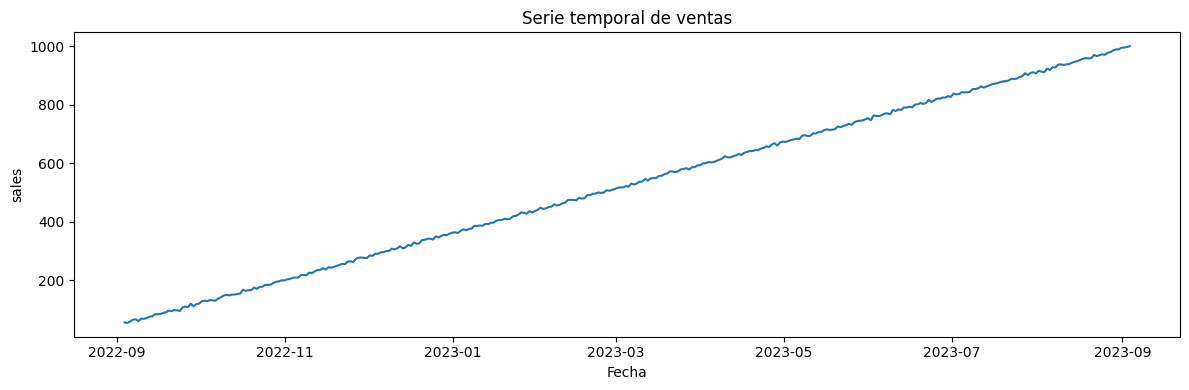

In [16]:
# ==============================
# 3) Tensor (frecuencia) y visualización
# ==============================

# Intentamos inferir la frecuencia de la serie
freq = pd.infer_freq(ts.index)
print("Frecuencia inferida (tensor):", freq)

# Si no se puede inferir, calculamos el delta más común
if freq is None:
    deltas = ts.index.to_series().diff().dropna()
    most_common = deltas.value_counts().head(1)
    print("Delta más común:", most_common.index[0], "→", most_common.iloc[0], "veces")

# Plot básico
plt.figure(figsize=(12, 4))
plt.plot(ts.index, ts.values)
plt.title("Serie temporal de ventas")
plt.xlabel("Fecha")
plt.ylabel(target_col)
plt.tight_layout()
plt.show()

## 4) Análisis: tendencia, estacionariedad y ruido/variabilidad

- **Tendencia:** la estimamos con una media móvil y también con la pendiente (regresión lineal simple).
- **¿Es estacionaria?:** aplicamos **Dickey-Fuller (ADF)**. Si `p-value < 0.05`, consideramos estacionaria.
- **Ruido/variabilidad:** miramos el componente residual de una descomposición estacional (si tiene sentido con la frecuencia).

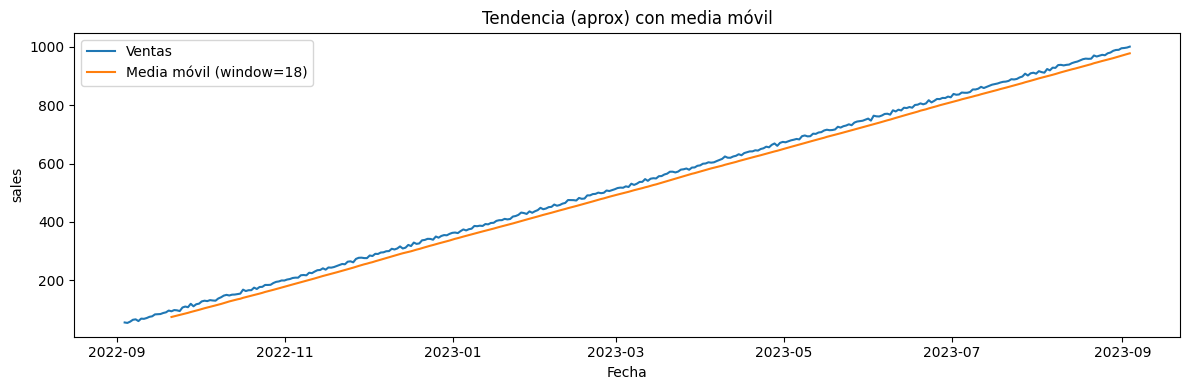

Pendiente aproximada (slope): 2.599958 -> tendencia creciente

ADF Test:
  Test statistic: 0.5454141937063742
  p-value       : 0.9861899815311063
  # lags        : 13
  # obs         : 352
  Critical values: {'1%': np.float64(-3.4490648539347544), '5%': np.float64(-2.8697861692116478), '10%': np.float64(-2.5711631253228306)}

Conclusión (estacionariedad): ❌ No estacionaria (p>=0.05)


In [17]:
# ==============================
# 4) Tendencia (rolling + pendiente) y Estacionariedad (ADF)
# ==============================

# Media móvil para ver tendencia (ventana adaptativa)
n = len(ts)
window = max(3, int(round(n * 0.05)))  # ~5% del tamaño, mínimo 3
rolling_mean = ts.rolling(window=window).mean()

plt.figure(figsize=(12, 4))
plt.plot(ts.index, ts.values, label="Ventas")
plt.plot(rolling_mean.index, rolling_mean.values, label=f"Media móvil (window={window})")
plt.title("Tendencia (aprox) con media móvil")
plt.xlabel("Fecha")
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()

# Pendiente (regresión lineal simple sobre el tiempo)
x = np.arange(len(ts))
slope = np.polyfit(x, ts.values, 1)[0]
print(f"Pendiente aproximada (slope): {slope:.6f} ->",
      "tendencia creciente" if slope > 0 else "tendencia decreciente" if slope < 0 else "sin tendencia clara")

# Dickey-Fuller
def adf_test(series):
    res = adfuller(series.dropna(), autolag="AIC")
    return {
        "test_statistic": res[0],
        "p_value": res[1],
        "lags": res[2],
        "nobs": res[3],
        "critical_values": res[4]
    }

adf = adf_test(ts)
print("\nADF Test:")
print("  Test statistic:", adf["test_statistic"])
print("  p-value       :", adf["p_value"])
print("  # lags        :", adf["lags"])
print("  # obs         :", adf["nobs"])
print("  Critical values:", adf["critical_values"])

print("\nConclusión (estacionariedad):",
      "✅ Estacionaria (p<0.05)" if adf["p_value"] < 0.05 else "❌ No estacionaria (p>=0.05)")

Period sugerido para descomposición: 7


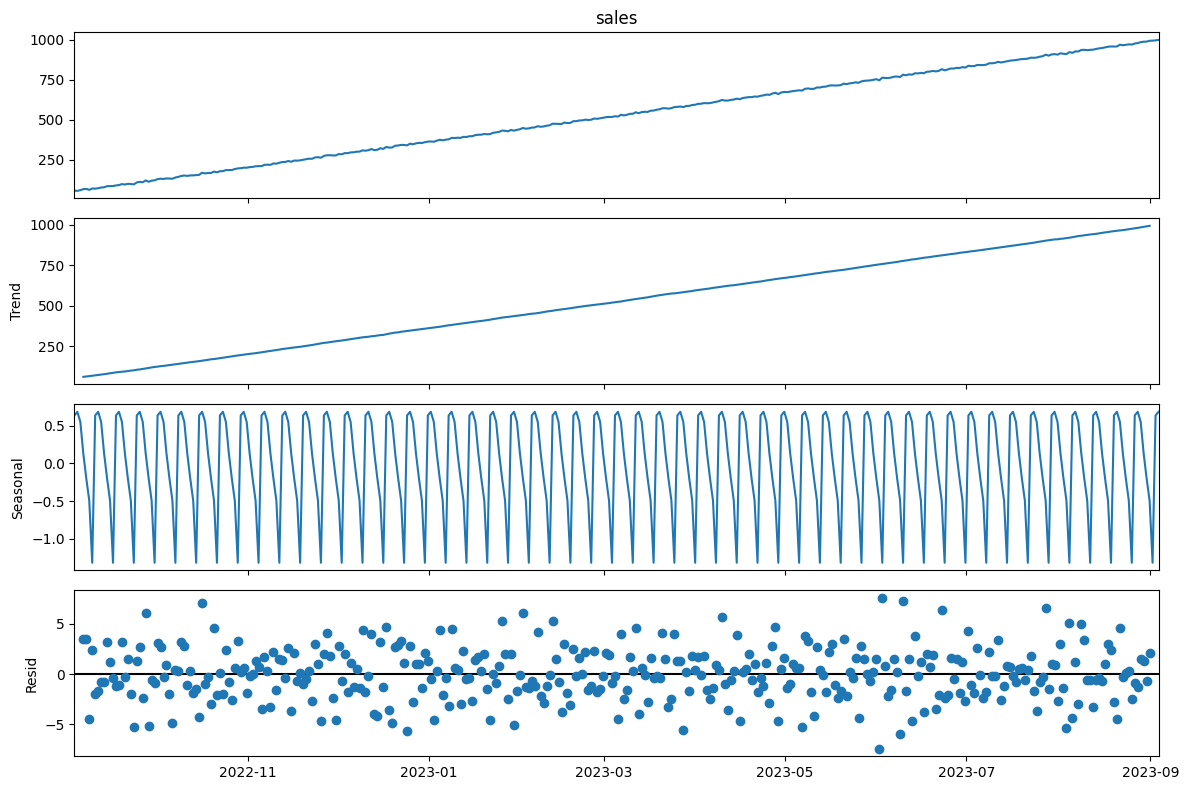

Residuo: media = 0.009088241986146663 | std = 2.6105392680278854
Interpretación rápida: a mayor std del residuo, mayor variabilidad/noise no explicado por tendencia/estacionalidad.


In [18]:
# ==============================
# 5) Descomposición estacional (si aplica)
# ==============================

# Elegimos un 'period' razonable según la frecuencia inferida.
# Ajusta si tu serie tiene otra estacionalidad.
period = None
if freq is not None:
    # Mensual -> 12; Semanal -> 52; Diario -> 7 (semana); Horario -> 24
    if "M" in freq:
        period = 12
    elif "W" in freq:
        period = 52
    elif "D" in freq:
        period = 7
    elif "H" in freq:
        period = 24

print("Period sugerido para descomposición:", period)

if period is None or len(ts) < 2 * (period if period else 1):
    print("⚠️ No se hace descomposición (frecuencia no inferida o serie muy corta para un period estable).")
else:
    decomposition = seasonal_decompose(ts, period=period, model="additive")
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid

    # Plot de componentes
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.tight_layout()
    plt.show()

    # Ruido/variabilidad: resumen del residuo
    resid_clean = resid.dropna()
    print("Residuo: media =", resid_clean.mean(), "| std =", resid_clean.std())
    print("Interpretación rápida: a mayor std del residuo, mayor variabilidad/noise no explicado por tendencia/estacionalidad.")

## 6) Train/Test Split (sin mezclar)

En series de tiempo **no** se debe mezclar aleatoriamente: se usa un split temporal.  
Tomaremos el **último 20%** como test (puedes cambiar `test_size`).

Train: 2022-09-03 17:10:08.079328 → 2023-06-21 17:10:08.079328 | n = 292
Test : 2023-06-22 17:10:08.079328 → 2023-09-03 17:10:08.079328 | n = 74


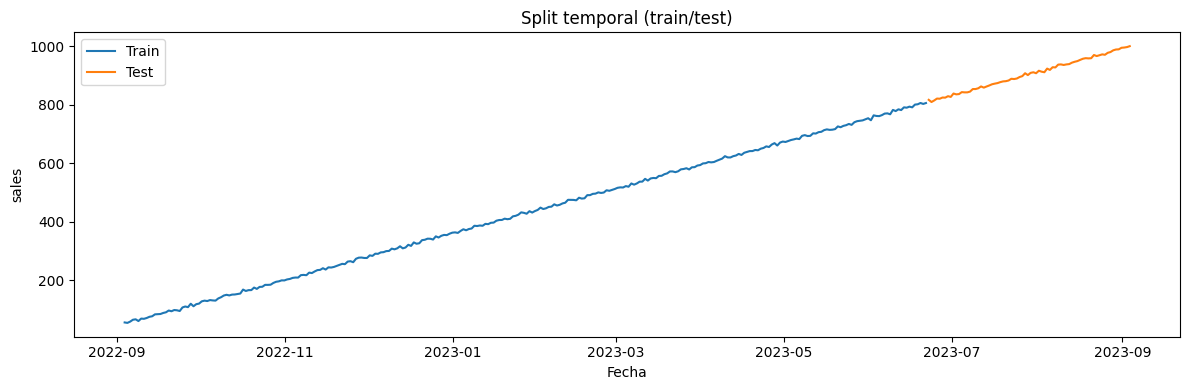

In [19]:
# ==============================
# 6) Split temporal: 80/20
# ==============================

test_size = 0.2
split_idx = int(len(ts) * (1 - test_size))

train_ts = ts.iloc[:split_idx]
test_ts  = ts.iloc[split_idx:]

print("Train:", train_ts.index.min(), "→", train_ts.index.max(), "| n =", len(train_ts))
print("Test :", test_ts.index.min(),  "→", test_ts.index.max(),  "| n =", len(test_ts))

plt.figure(figsize=(12, 4))
plt.plot(train_ts.index, train_ts.values, label="Train")
plt.plot(test_ts.index, test_ts.values, label="Test")
plt.title("Split temporal (train/test)")
plt.xlabel("Fecha")
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()

## 7) Entrenamiento ARIMA (búsqueda de parámetros)

- Si `auto_arima` está disponible, lo usamos para estimar automáticamente `(p, d, q)` y (si aplica) estacionalidad.
- Si no, hacemos un mini grid-search con `statsmodels` (más lento y básico).

In [20]:
# ==============================
# 7) Entrenamiento ARIMA
# ==============================

model = None

if AUTO_ARIMA_AVAILABLE:
    # Reglas simples para estacionalidad: si la frecuencia es mensual, usamos m=12; semanal m=52; diaria m=7.
    m = 1
    seasonal = False
    if freq is not None:
        if "M" in freq:
            m = 12; seasonal = True
        elif "W" in freq:
            m = 52; seasonal = True
        elif "D" in freq:
            m = 7; seasonal = True

    print(f"Configuración auto_arima: seasonal={seasonal}, m={m}")
    model = auto_arima(
        train_ts,
        seasonal=seasonal,
        m=m,
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True
    )
    print("\nMejor modelo:", model.order, "estacional:", getattr(model, "seasonal_order", None))

else:
    # Fallback simple con statsmodels
    from statsmodels.tsa.arima.model import ARIMA

    best_aic = np.inf
    best_order = None
    best_model = None

    # Grid pequeño para no tardar demasiado
    for p in range(0, 4):
        for d in range(0, 3):
            for q in range(0, 4):
                try:
                    tmp = ARIMA(train_ts, order=(p, d, q)).fit()
                    if tmp.aic < best_aic:
                        best_aic = tmp.aic
                        best_order = (p, d, q)
                        best_model = tmp
                except Exception:
                    continue

    model = best_model
    print("Mejor order:", best_order, "| AIC:", best_aic)

model

Configuración auto_arima: seasonal=True, m=7
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1477.640, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1675.428, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1574.824, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1472.428, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1763.761, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1475.165, Time=0.33 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=1472.511, Time=0.65 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=1471.456, Time=0.34 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=1472.463, Time=1.02 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=1470.355, Time=1.50 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=1678.420, Time=0.25 sec
 AR

,order,"(0, ...)"
,seasonal_order,"(2, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,True
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,{}
,trend,None
,with_intercept,True


## 8) Predicción en el conjunto de test y evaluación

Calculamos métricas típicas:
- **MAE**
- **RMSE**
- (Opcional) **MAPE** si no hay ceros.

MAE : 2.1613
RMSE: 2.7297
MAPE: 0.24%


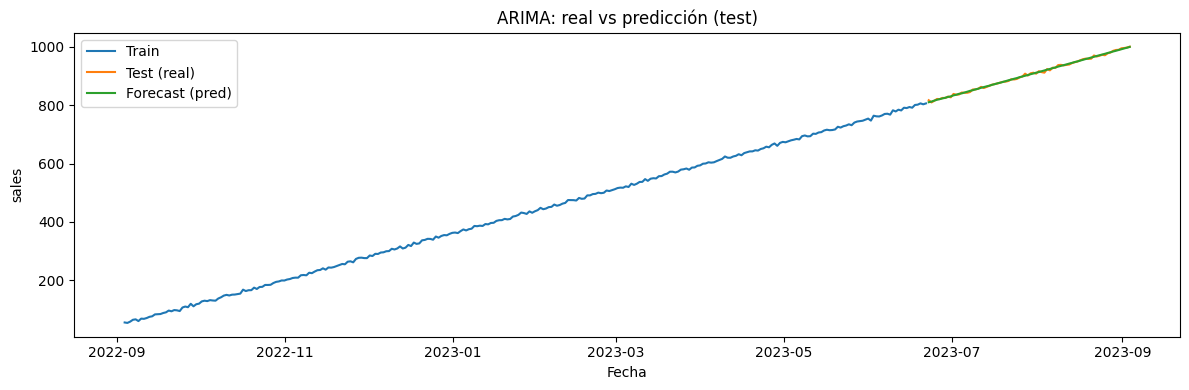

In [21]:
# ==============================
# 8) Forecast sobre el horizonte del test
# ==============================
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

h = len(test_ts)

if AUTO_ARIMA_AVAILABLE:
    y_pred = pd.Series(model.predict(n_periods=h), index=test_ts.index)
else:
    # statsmodels ARIMA
    fc = model.forecast(steps=h)
    y_pred = pd.Series(fc, index=test_ts.index)

# Métricas

mae = mean_absolute_error(test_ts, y_pred)
rmse = np.sqrt(mean_squared_error(test_ts, y_pred))

# MAPE (cuidado con ceros)
eps = 1e-9
mape = np.mean(np.abs((test_ts - y_pred) / (np.abs(test_ts) + eps))) * 100

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot comparativo
plt.figure(figsize=(12, 4))
plt.plot(train_ts.index, train_ts.values, label="Train")
plt.plot(test_ts.index, test_ts.values, label="Test (real)")
plt.plot(y_pred.index, y_pred.values, label="Forecast (pred)")
plt.title("ARIMA: real vs predicción (test)")
plt.xlabel("Fecha")
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()

## 9) Guardado del modelo

Se guardará en `models/` dentro del repo.
- Con `auto_arima` (pmdarima) es común usar `model.save(...)`.
- Con el fallback de statsmodels, usamos `pickle`.

In [24]:
# ==============================
# 9) Guardado del modelo (SIEMPRE con joblib)
# ==============================

from pathlib import Path
import joblib

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

out_path = models_dir / "arima_sales_model.joblib"

# Regla:
# - Si usaste auto_arima -> normalmente "model" es el modelo final
# - Si usaste statsmodels ARIMA -> lo correcto es guardar el resultado ajustado (ej: model_fit)
#   porque "ARIMA" (sin fit) NO tiene .save() y además no contiene los parámetros estimados.

if AUTO_ARIMA_AVAILABLE:
    # pmdarima (auto_arima) es serializable con joblib
    joblib.dump(model, out_path)

else:
    # statsmodels: preferimos guardar el objeto "fiteado" si existe
    if "model_fit" in globals() and model_fit is not None:
        joblib.dump(model_fit, out_path)
    else:
        # fallback por si tu variable se llama distinto; guarda lo que tengas como "model"
        joblib.dump(model, out_path)

print("Modelo guardado en:", out_path)


Modelo guardado en: models/arima_sales_model.joblib
